# Project 'WHO suicide statistics predictions'

WHO suicide statistics predictions for European Union country-members. 
WHO Suicide Statistics data (WHO Mortality Database) for each EU member country, year, age groups and sex. 
Temporal dependencies in some cases (for Portugal and Slovenia) do not cover all periods of membering in the EU.

Additional metrics/features for primary WHO Mortality Database :
* GDP per capita(from World Bank Open Data);
* GINI index(from World Bank Open Data);
* Foreign Exchange Reserves (from World Bank Open Data);
* Unemployment (from World Bank Open Data);
* Inflation Rate (from World Bank Open Data);
* ARMS export (from World Bank Open Data);
* ARMS import (from World Bank Open Data);
* Life length (from World Bank Open Data);
* Corruption perception index (from Transparency);
* Average January weather temperature (from Climate Change Knowledge Portal);
* Average July weather temperature (from Climate Change Knowledge Portal).

## Loading data set and choosing random seed

In [2]:
from ml_functions import *

Make results reproducible by emphasizing random seed.

In [3]:
np.random.seed(seed=158)

## Loading data set

In [4]:
path_material = pathlib.Path('data\\raw_data.csv')

In [5]:
df_raw = pd.read_csv(path_material, low_memory=False)

## Data pre-processing

Brief overall data set description.

In [6]:
df_raw.describe()

,year,population,foreign_exch_reserve,GPD_per_cap,Unemployment,Inflation_rate,Life_length_expectancy,GINI,ARMS_export,ARMS_import,Corruption_perception,Temperature_JAN,Temperature_JUL,suicides_no
count,7248.000000,7.248000e+03,7.176000e+03,7248.000000,7092.000000,7248.000000,7248.000000,4656.000000,4.872000e+03,6.384000e+03,4764.000000,7248.000000,7248.000000,7248.000000
mean,2001.774834,1.743408e+06,3.469842e+10,26893.020251,8.820021,3.470996,77.562979,31.333763,6.209064e+08,2.277538e+08,21.985516,1.868540,19.271537,217.996551
std,10.055130,2.235278e+06,3.911449e+10,18015.963059,4.311936,3.911775,2.718098,3.608685,8.498247e+08,3.152652e+08,26.615663,5.127656,3.454063,425.938170
min,1979.000000,5.900000e+03,9.746575e+07,3861.948500,1.482400,-4.478103,70.865854,23.000000,0.000000e+00,0.000000e+00,3.330000,-16.194000,12.571100,0.000000
25%,1995.000000,3.024238e+05,6.400005e+09,13585.207562,5.856900,1.417741,75.475287,28.200000,2.500000e+07,2.400000e+07,6.100000,-1.093000,16.649850,9.000000
50%,2004.000000,7.447485e+05,2.160458e+10,23102.007735,7.865600,2.452733,77.636585,31.350000,2.080000e+08,1.045000e+08,8.000000,2.732625,18.887950,63.000000
75%,2010.000000,2.538383e+06,4.807903e+10,35575.159547,10.554500,4.053958,79.793293,34.300000,9.510000e+08,2.865000e+08,42.000000,5.044645,21.743575,214.000000
max,2016.000000,1.314881e+07,2.490000e+11,118823.648400,27.466200,24.506067,83.229268,39.000000,4.037000e+09,2.167000e+09,92.000000,22.723500,29.786000,3427.000000


### Refactor columns titles

Initialize **refactor_titles()** function (it changes all titles to lower cases along with substituting and dropping several uncommon characters) on the DataFrame's columns.

In [7]:
df_raw.columns = refactor_titles(df_raw)

Substituotion of " " occured 0 times.
Substituotion of "-" occured 0 times.
Substituotion of ":" occured 0 times.


### Update 'corruption perception' feature as evaluation changed from 2012

After 2012 Corruption perception evaluation changes from range 10 to range 100.
In order to generalize column, all values after 2012 will be divided by 10.

In [8]:
df_raw['corruption_perception'] = df_raw['corruption_perception'].apply(lambda x: x/10 if x > 10 else x)

### NaN values | part 1/2

Check the DataFrame for null-values.

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 7248 non-null   object 
 1   year                    7248 non-null   int64  
 2   sex                     7248 non-null   object 
 3   age                     7248 non-null   object 
 4   population              7248 non-null   int64  
 5   foreign_exch_reserve    7176 non-null   float64
 6   gpd_per_cap             7248 non-null   float64
 7   unemployment            7092 non-null   float64
 8   inflation_rate          7248 non-null   float64
 9   life_length_expectancy  7248 non-null   float64
 10  gini                    4656 non-null   float64
 11  arms_export             4872 non-null   float64
 12  arms_import             6384 non-null   float64
 13  corruption_perception   4764 non-null   float64
 14  temperature_jan         7248 non-null   

####  *ARMS import* and *ARMS export* features

All empty values in both ARMS import and ARMS export columns will be filled with '0', as these countries didn't participate neither in ARMS import nor in ARMS export activities.

In [10]:
df_raw['arms_import'].fillna(0, inplace=True)
df_raw['arms_export'].fillna(0, inplace=True)

#### *Foreign exchange* reserve and *Unemployment* features

**nan_columns_by_country()** function derives column names containing at least one NaN value, puts them into a list, assigns it to a variable, attaches country names where NaN appeared and returns a dictionary with countries.

In [11]:
columns_nan_dict = nan_columns_by_country(df_raw,'country')

* 22 categories in column "country" with at least one NaN in "corruption_perception".
* 1 categories in column "country" with at least one NaN in "foreign_exch_reserve".
* 16 categories in column "country" with at least one NaN in "gini".
* 4 categories in column "country" with at least one NaN in "unemployment".


Function returned 4 columns: 
* foreign_exch_reserve;
* unemployment;
* gini;
* corruption_perception;

Fill NaN values in 'unemployment' column using **fillna()** function as only 4 countries have missing values.

In [12]:
backfilling_nan_by_country(df=df_raw, columns_nan_dict=columns_nan_dict,
                           target_column='unemployment', category_column = 'country')

'NaN values were filled in "unemployment"" column'

Fill NaN values in 'foreign_exch_reserve' column using **fillna()** function as only one country have missing values.

In [13]:
backfilling_nan_by_country(df=df_raw,columns_nan_dict=columns_nan_dict,
                           target_column='foreign_exch_reserve', category_column = 'country')

'NaN values were filled in "foreign_exch_reserve"" column'

#### Remaining NaN columns

Observe using **missing_values()** remaining NaN columns.

Column "gini" has 2592 missing values.
Column "corruption_perception" has 2484 missing values.


<AxesSubplot:>

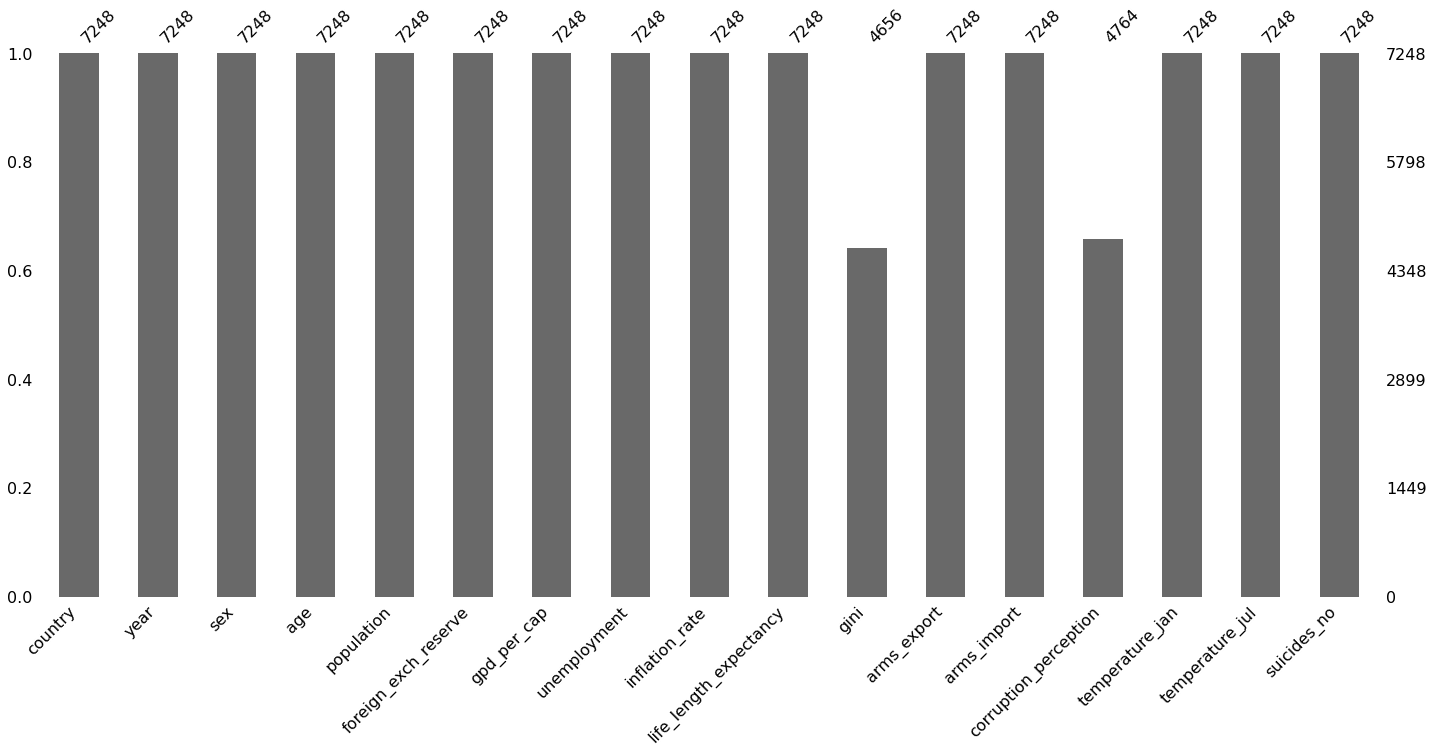

In [14]:
missing_values(df_raw)

***'gini'*** and ***'corruption_perception'*** columns still remain with NaN values.

### Label Encoding

Define binary cardinality columns.

In [15]:
binary_cardinality_cols = [col_name for col_name in df_raw.columns if df_raw[col_name].nunique() < 3 and 
                                                                   df_raw[col_name].dtype == 'object']; 
print(f' Binary cardinality columns: {binary_cardinality_cols}')

 Binary cardinality columns: ['sex']


Next action is Label Encoding for binary cardinality columns.

In [16]:
label_df_raw = df_raw.copy()
label_encoder = LabelEncoder()

for col in binary_cardinality_cols:
    label_df_raw[col] = label_encoder.fit_transform(df_raw[col])

DataFrame first 12 rows overview after Label Encoding.

In [17]:
label_df_raw.head(12)

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
0,Austria,1995,0,15-24 years,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,19
1,Austria,1995,0,25-34 years,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,59
2,Austria,1995,0,35-54 years,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,136
3,Austria,1995,0,5-14 years,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,0
4,Austria,1995,0,55-74 years,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,141
5,Austria,1995,0,75+ years,341098,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,100
6,Austria,1995,1,15-24 years,509262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,134
7,Austria,1995,1,25-34 years,707468,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,237
8,Austria,1995,1,35-54 years,1074328,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,437
9,Austria,1995,1,5-14 years,483644,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,8


### One-Hot-Encoder

After committing label encoding for binary cardinality columns next mvpe is to check low cardinality columns.
Maximum number of unique values for low cardinality columns is higher than 2 but less than 16.

In [18]:
low_cardinality_cols = [col_name for col_name in df_raw.columns if 2 < df_raw[col_name].nunique() < 16 and 
                                                                   df_raw[col_name].dtype == 'object']; 
print(f' Low cardinality columns: {low_cardinality_cols}')

 Low cardinality columns: ['age']


Adjust One-Hot-Encoding and reform low cardinality columns.

In [19]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df_raw[low_cardinality_cols]))

OH_cols_df.index = df_raw.index 
OH_cols_df.rename(columns = {0: '15-24 years',
                             1: '25-34 years',
                             2: '35-54 years',
                             3: '5-14 years',
                             4: '55-74 years',
                             5: '75+ years'}, inplace=True)

num_df = label_df_raw.drop(low_cardinality_cols, axis=1) 
OH_df = pd.concat([num_df,OH_cols_df], axis=1)

DataFrame overview after One-Hot-Encoding.

In [20]:
OH_df

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,corruption_perception,temperature_jan,temperature_jul,suicides_no,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Austria,1995,0,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,19,1.0,0.0,0.0,0.0,0.0,0.0
1,Austria,1995,0,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,59,0.0,1.0,0.0,0.0,0.0,0.0
2,Austria,1995,0,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,136,0.0,0.0,1.0,0.0,0.0,0.0
3,Austria,1995,0,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,0,0.0,0.0,0.0,1.0,0.0,0.0
4,Austria,1995,0,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,141,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,United Kingdom,2015,1,4408293,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,596,0.0,1.0,0.0,0.0,0.0,0.0
7244,United Kingdom,2015,1,8692440,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,1579,0.0,0.0,1.0,0.0,0.0,0.0
7245,United Kingdom,2015,1,3840476,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,4,0.0,0.0,0.0,1.0,0.0,0.0
7246,United Kingdom,2015,1,6716557,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,906,0.0,0.0,0.0,0.0,1.0,0.0


### Train and Test set split

Divide all data into ***test*** as 20% and ***train*** as 80% of the data set.  

In [21]:
msk = np.random.rand(len(df_raw)) < 0.8

Initialize two DataFrames according to previous separation.

In [22]:
train = OH_df[msk]
test = OH_df[~msk]

Split train data set into ***X*** and ***y*** and test data set into ***X_test*** and ***y_test***.

In [23]:
X,y = train.drop(columns=['suicides_no']), train['suicides_no']
X_test,y_test = test.drop(columns=['suicides_no']), test['suicides_no']

### Train and Validation set split

Split into ***train*** as 75% and ***validation*** as 25% of the both ***X*** and ***y*** set parts and print their shapes.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=158)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)

Train set: (4304, 21) (4304,)
Validation set: (1435, 21) (1435,)


### NaN values | part 2/2

#### Drop 'country' column and  use Simple Imputer

Impute the remaining two columns: ***'gini'*** and ***'corruption_perception'***.
Restore columns names and indexes. Drop *country* column.
Imputing the mean value should be after splitting the data set into train/validation/test in order not to leak data.

In [25]:
features = X_train.columns[1:]

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[features]))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[features]))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test[features]))

imputed_X_train.columns = X_train[features].columns
imputed_X_valid.columns = X_valid[features].columns
imputed_X_test.columns = X_test[features].columns

imputed_X_train.index = X_train[features].index
imputed_X_valid.index = X_valid[features].index
imputed_X_test.index = X_test[features].index

#### Changing several formats

Form a dictionary for a DataFrame columns with less PC memory consuming data types.

In [26]:
formats = {'sex': 'int8','15-24 years': 'int8',
           '25-34 years': 'int8','35-54 years': 'int8',
           '5-14 years': 'int8','55-74 years': 'int8',
           '75+ years': 'int8', 'year': 'int32'}

BEFORE PRE-PROCESSING

In [27]:
X_train[:2] 

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,France,2010,1,8518205,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.7,...,103000000.0,6.8,1.06260,20.9197,0.0,0.0,1.0,0.0,0.0,0.0
4011,Italy,1985,0,3898700,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,NaN,...,206000000.0,NaN,0.89887,21.7534,0.0,0.0,0.0,1.0,0.0,0.0


#### Final train/validation/test

Construct final train/validation/test DataFrames.

In [28]:
X_train = imputed_X_train.copy().astype(formats)
X_valid = imputed_X_valid.copy().astype(formats)
X_test = imputed_X_test.copy().astype(formats)

AFTER PRE-PROCESSING

In [29]:
X_train[:2]

,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,2010,1,8518205.0,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.700000,866000000.0,103000000.0,6.800000,1.06260,20.9197,0,0,1,0,0,0
4011,1985,0,3898700.0,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,31.346157,920000000.0,206000000.0,6.768767,0.89887,21.7534,0,0,0,1,0,0


Final check for train/validation/test set shapes.

In [30]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4304, 20) (4304,)
Validation set: (1435, 20) (1435,)
Test set: (1509, 20) (1509,)


### Linear Regression model

Initialize Linear Regression baseline model and print all scores.

In [31]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print_score(regr,X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		260.86301673  
     RMSE Validation set: 	271.80050038 
     r² Train set: 		0.61845014 
     r² Validation set: 	0.59765327 
     MAE Train set: 		159.38991589 
     MAE Validation set: 	164.793297


Linear Regression Coefficients and Intercept value along with column names.

In [32]:
coefs = list(regr.coef_)
col_names = list(X_train.columns)
val = zip(col_names,coefs)
for coef_ in val:
    print(coef_)
print()
print ('Intercept: ',regr.intercept_)

('year', -0.7897392493634116)
('sex', 215.3742093794777)
('population', 0.00011511300141388205)
('foreign_exch_reserve', 5.050452346601324e-10)
('gpd_per_cap', 0.0006340483893966887)
('unemployment', 0.2877693543616852)
('inflation_rate', -7.924095389724259)
('life_length_expectancy', -18.301630583978934)
('gini', -8.661009978887858)
('arms_export', 5.703109439015665e-08)
('arms_import', -9.055167198724951e-08)
('corruption_perception', 4.116805003670106)
('temperature_jan', -3.5280112291505543)
('temperature_jul', 7.963009777002055)
('15-24 years', -83.52023365665859)
('25-34 years', -24.337837939974307)
('35-54 years', 88.14604294531544)
('5-14 years', -169.9008140282418)
('55-74 years', 108.87013385043984)
('75+ years', 80.74270882911955)

Intercept:  2990.6269708235673


####  Robust Scaler on Linear Regression model

Use RobustScaler() for scaling ***X_train*** and ***X_valid***

In [33]:
scaler = RobustScaler()
X_train_robust_scaler = scaler.fit_transform(X_train.copy())
X_valid_robust_scaler = scaler.transform(X_valid.copy())

regr_vol_2 = linear_model.LinearRegression()
regr_vol_2.fit(X_train_robust_scaler, y_train)

print_score(regr_vol_2,X_train_robust_scaler, X_valid_robust_scaler,y_train, y_valid)

     RMSE Train set: 		260.86301673  
     RMSE Validation set: 	271.8004372 
     r² Train set: 		0.61845014 
     r² Validation set: 	0.59765345 
     MAE Train set: 		159.38977354 
     MAE Validation set: 	164.79312944


#### MinMax Scaler on Linear Regression model

Use MinMaxScaler() for scaling ***X_train*** and ***X_valid***

In [34]:
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train.copy())
X_valid_norm = norm.transform(X_valid.copy())

regr_vol_3 = linear_model.LinearRegression()
regr_vol_3.fit(X_train_norm, y_train)

print_score(regr_vol_3,X_train_norm, X_valid_norm,y_train, y_valid)

     RMSE Train set: 		260.88942496  
     RMSE Validation set: 	271.66029976 
     r² Train set: 		0.61837288 
     r² Validation set: 	0.59806824 
     MAE Train set: 		159.62523234 
     MAE Validation set: 	164.74425087


#### Standard Scaler on Linear Regression model

Use StandardScaler() for scaling ***X_train*** and ***X_valid***

In [35]:
standard_scaler = StandardScaler()
X_train_standard_scaler = standard_scaler.fit_transform(X_train.copy())
X_valid_standard_scaler = standard_scaler.transform(X_valid.copy())

regr_vol_4 = linear_model.LinearRegression()
regr_vol_4.fit(X_train_standard_scaler, y_train)

print_score(regr_vol_4,X_train_standard_scaler, X_valid_standard_scaler,y_train, y_valid)

     RMSE Train set: 		260.86299656  
     RMSE Validation set: 	271.79908062 
     r² Train set: 		0.6184502 
     r² Validation set: 	0.59765747 
     MAE Train set: 		159.38857959 
     MAE Validation set: 	164.79080653


None of above used scaling methods did not improve results much. As I was told on https://stackoverflow.com/ (by user ***Ben Reiniger***): Scaling does not affect an unpenalized regression. It can improve convergence of the solver, but if the model is converging satisfactorily on the raw data, the results will be the same.

####  Linear Regression model's Heatmap

Heatmap shows correlation between independent variables. 
According to result some vairables can be dropped others can be merged.

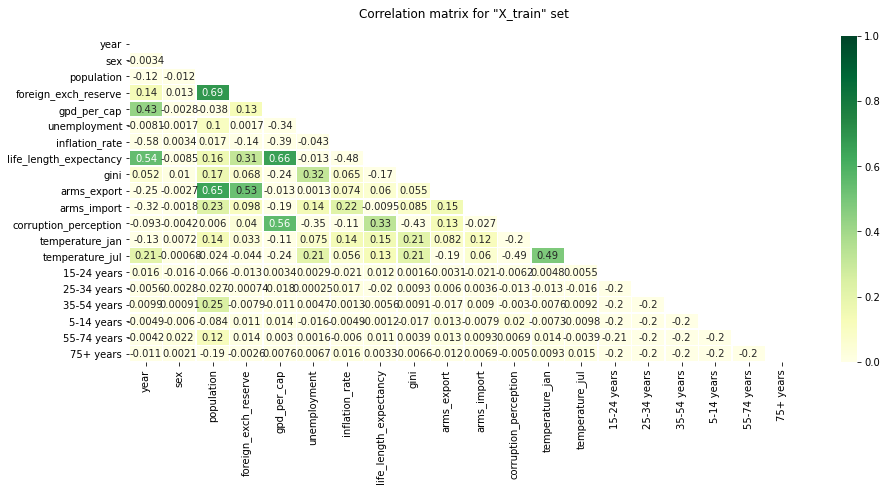

In [36]:
f, ax = plt.subplots(figsize=(15, 6))
mask_corr = np.triu(np.ones_like(X_train.corr(method='pearson'), dtype=bool))
sns.heatmap(X_train.corr(method='pearson'), annot=True, mask=mask_corr, robust=False,cmap='YlGn', 
                                                                linewidths=.6, ax=ax, vmin=0, vmax=1)
plt.title('Correlation matrix for "X_train" set', y=1.04)
plt.show()

#### Linear Regression model's Validation set predictions scatter plot

Compare predictions and real values using scatter plot and figure out how many negative predictions occurred.

Positive "y" predicitons: 1084
Negative "y" predictions: 351


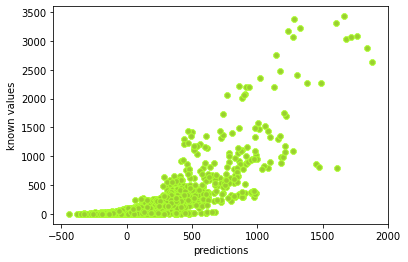

In [37]:
plt.scatter(regr.predict(X_valid),y_valid.to_numpy(),color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(-500,2200,500)))
plt.xlabel('predictions')
plt.ylabel('known values')
preds_lin = regr.predict(X_valid)
print(f'Positive "y" predicitons: {preds_lin[preds_lin>=0].size}')
print(f'Negative "y" predictions: {preds_lin[preds_lin<0].size}')

<br>Inferring very terrible predictions for Linear Regression model, even negative ones for low dependent variable's values.</br> <br>Use a zip() iterator and take the first ten values from *'X_valid' predictions and first ten values from *'y_valid'* and print them out.</br>

In [38]:
pprint(tuple(zip(list(regr.predict(X_valid)[:10]),(list(y_valid.to_numpy()[:10])))))

((-230.21485151366778, 0),
 (87.89627323287323, 53),
 (-223.64576155183386, 3),
 (128.01080020063455, 17),
 (-332.05814228307963, 1),
 (-44.65449690454261, 16),
 (99.59318735159422, 71),
 (246.63179185090712, 132),
 (-86.56552419252739, 15),
 (226.63119149226577, 111))


#### Linear Regression model with logarithmic dependent variable

Take the log of the value plus 1 of the ***y_train*** and ***y_valid***, as data set *y* has *zero* values and initialize another one Linear Regression model. 

In [39]:
y_train_log = np.log1p(np.clip(y_train.copy(), 0, None))
y_valid_log = np.log1p(np.clip(y_valid.copy(), 0, None))

regr_vol_5 = linear_model.LinearRegression()
regr_vol_5.fit(X_train, y_train_log)
print_score_log(regr_vol_5,X_train, X_valid,y_train_log, y_valid_log)

     RMSE Train set: 		865.59686638  
     RMSE Validation set: 	877.38524479 
     r² Train set: 		-3.20104783 
     r² Validation set: 	-3.19257297 
     MAE Train set: 		167.06285298 
     MAE Validation set: 	156.33280553


<br>Getting better MAE but quite lower RMSE value and even negative r².</br>
<br>Need to compare predictions after logarithmic actions and real values using scatter plot and figure out if any outliers appear.</br>

#### Predictions after logarithmic actions and real values in scatter plot 

<br> <span style="color:red">Red</span> line is the maximum dependent value from train set.</br>

Positive "y" predicitons: 1397
Negative "y" predictions: 38


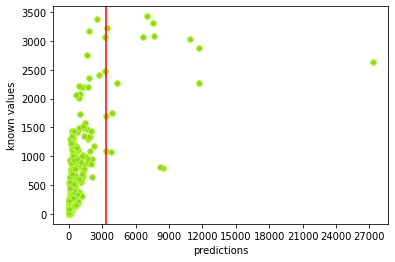

In [40]:
plt.scatter(np.expm1(regr_vol_5.predict(X_valid)),np.expm1(y_valid_log),color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(0,28000,3000)))
plt.xlabel('predictions')
plt.ylabel('known values')
plt.axvline(np.max(y_train),color='red')
preds_lin = np.expm1(regr_vol_5.predict(X_valid))
print(f'Positive "y" predicitons: {preds_lin[preds_lin>=0].size}')
print(f'Negative "y" predictions: {preds_lin[preds_lin<0].size}')

One huge outlier of value about 27,328 occurs (exact value is 27,327.513086656043) and several mildly dispersed from the maximum of known values. 

#### Linear Regression model with scaled and logarithmic dependent variable

Take the log of the value plus 1 of the y_train and y_valid, and then scale them with StandardScaler().

In [41]:
y_train_log = np.log1p(np.clip(y_train.copy(), 0, None))
y_valid_log = np.log1p(np.clip(y_valid.copy(), 0, None))
y_test_log = np.log1p(np.clip(y_test.copy(), 0, None))

standard_scaler_y = StandardScaler()
y_train_log_scal = standard_scaler_y.fit_transform(y_train_log[:,None].copy())
y_valid_log_scal = standard_scaler_y.transform(y_valid_log[:,None].copy())

regr_vol_6 = linear_model.LinearRegression()
regr_vol_6.fit(X_train, y_train_log_scal)
preds = regr_vol_6.predict(X_valid)

And reverse all results back for scoring.

In [42]:
preds_back = standard_scaler_y.inverse_transform(preds)
y_preds_back = np.expm1(preds_back)
print(f' \
    RMSE Validation set: \t{np.sqrt(mean_squared_error(y_preds_back, y_valid.to_numpy()))} \n \
    r² Validation set: \t{r2_score(y_valid,y_preds_back)} \n \
    MAE Validation set: \t{mean_absolute_error(y_valid, y_preds_back)}')

     RMSE Validation set: 	877.348269800011 
     r² Validation set: 	-3.192219607942273 
     MAE Validation set: 	156.32958899940257


#### <span style="color:teal"> Catching outliers and upgrading Linear Regression model</span>

Begin with finding tremendous outlier (~27k) in LinearRegression model which was spotted in the plot above.

In [43]:
preds_find_outlier = np.expm1(regr_vol_5.predict(X_valid))
preds_list = list(preds_find_outlier); 
print('Outlier index:', preds_list.index(27327.513086656043))

Outlier index: 856


Search for *856* index it in *X_valid* set and retrieve it from primary DataFrame.

In [44]:
case_856 = X_valid.copy()
case_856['num'] = list(range(0,1435,1))
index_856 = case_856[case_856['num'] == 856].index.values.astype(int)[0]
df_raw.iloc[[index_856]]

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
1352,Germany,2009,male,35-54 years,12872657,1.790000e+11,41485.90165,7.7416,0.312738,79.836585,30.5,2.461000e+09,339000000.0,8.0,-1.7876,18.4188,2628


Find out other outliers and display them in one DataFrame.

In [45]:
outlier_indexes = []

for n,i in enumerate(preds_list):
    if i > y_valid.max():
        outlier_indexes.append(n)

In [46]:
indexes_to_df = case_856[case_856['num'].isin(outlier_indexes)].index
df_raw.iloc[indexes_to_df,:][5:12]

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
1268,Germany,2002,male,35-54 years,12777078,8.914254e+10,25077.72908,8.4819,1.420806,78.229268,29.9,9.060000e+08,71000000.0,7.3,1.32824,17.9755,3088
1220,Germany,1998,male,35-54 years,11704700,1.080000e+11,27289.05936,9.7883,0.911185,77.475610,28.3,1.808000e+09,543000000.0,7.9,2.32611,16.6749,3039
1352,Germany,2009,male,35-54 years,12872657,1.790000e+11,41485.90165,7.7416,0.312738,79.836585,30.5,2.461000e+09,339000000.0,8.0,-1.78760,18.4188,2628
7220,United Kingdom,2013,male,35-54 years,8656572,1.190000e+11,43444.53300,7.5242,2.291667,81.004878,33.2,1.608000e+09,494000000.0,7.6,3.51217,16.4975,1743
6908,United Kingdom,1987,male,35-54 years,6997144,5.091793e+10,13118.58653,11.0191,4.148922,75.280488,NaN,3.597000e+09,212000000.0,NaN,0.64941,14.5665,1072
1382,Germany,2012,female,35-54 years,12089833,2.490000e+11,43858.36306,5.3794,2.008491,80.539024,NaN,7.470000e+08,131000000.0,7.9,1.74032,17.7462,810
2672,France,1997,male,35-54 years,8161700,5.469313e+10,24228.94235,12.5662,1.203943,78.304878,NaN,3.272000e+09,223000000.0,NaN,1.93680,18.5886,3224


Plot suicides variance across the EU countries.

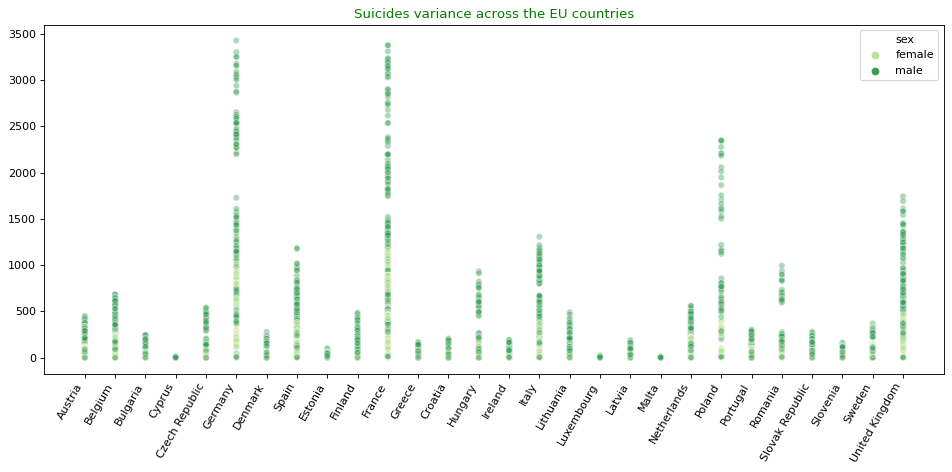

In [47]:
plt.figure(figsize=(12, 6), dpi=80)
sns.scatterplot(df_raw['country'],df_raw['suicides_no'],hue=df_raw['sex'], marker='8',alpha=0.4, palette="YlGn")
plt.xticks(rotation=60, ha='right')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Suicides variance across the EU countries', color='green')
plt.tight_layout()

#### Dropping outliers from Linear Regression model's valdiation set

Drop 14 outliers from the validation set and evaluate the score.

In [48]:
X_valid_new = X_valid.copy()
y_valid_new = y_valid.copy()

X_valid_new.drop(X_valid_new.index[outlier_indexes],inplace=True)
y_valid_new.drop(X_valid_new.index[outlier_indexes],inplace=True)

y_train_log1p = np.log1p(np.clip(y_train.copy(), 0, None))
y_valid_log1p = np.log1p(np.clip(y_valid_new.copy(), 0, None))

regr_vol_7 = linear_model.LinearRegression()
regr_vol_7.fit(X_train, y_train_log1p)
print_score_log(regr_vol_7,X_train, X_valid_new,y_train_log1p, y_valid_log1p)
predictions = regr_vol_7.predict(X_valid)

     RMSE Train set: 		865.59686638  
     RMSE Validation set: 	364.43468339 
     r² Train set: 		-3.20104783 
     r² Validation set: 	0.25657843 
     MAE Train set: 		167.06285298 
     MAE Validation set: 	130.46499966


#### Find out which independent features cause such a low Linear Regression model's score

Make analysis using SHAP (SHapley Additive exPlanations) library and examine which features force row 856 to infer bad prediction.

In [49]:
row_to_show = 856
data_for_prediction = X_valid.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [50]:
explainer = shap.LinearExplainer(regr_vol_5, X_train,feature_perturbation="interventional")
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Drop three columns from all sets and evaluate the score.

In [51]:
X_train_shap = X_train.copy()
X_valid_shap = X_valid.copy()
X_test_shap = X_test.copy()

In [52]:
features=['population','foreign_exch_reserve','arms_export']

In [53]:
X_valid_shap.drop(columns=features, inplace=True)
X_train_shap.drop(columns=features, inplace=True)
X_test_shap.drop(columns=features, inplace=True)

In [54]:
y_train_log1p = np.log1p(np.clip(y_train.copy(), 0, None))
y_valid_log1p = np.log1p(np.clip(y_valid.copy(), 0, None))
y_test_log1p = np.log1p(np.clip(y_test.copy(), 0, None))

regr_vol_8 = linear_model.LinearRegression()
regr_vol_8.fit(X_train_shap, y_train_log1p)
print_score_log(regr_vol_8,X_train_shap, X_valid_shap,y_train_log1p, y_valid_log1p.to_numpy())
predictions = regr_vol_8.predict(X_valid_shap)

     RMSE Train set: 		393.64992297  
     RMSE Validation set: 	404.08745256 
     r² Train set: 		0.13114638 
     r² Validation set: 	0.11069505 
     MAE Train set: 		168.60134481 
     MAE Validation set: 	166.82768312


#### Test set score

Test set score taking with logarithmic transformation on dependent value.

In [55]:
print_score_log(regr_vol_8,X_train_shap, X_test_shap,y_train_log1p, y_test_log1p)

     RMSE Train set: 		393.64992297  
     RMSE Validation set: 	410.26569429 
     r² Train set: 		0.13114638 
     r² Validation set: 	0.10376401 
     MAE Train set: 		168.60134481 
     MAE Validation set: 	172.83098821


Test set score taking without logarithmic transformation on dependent value.

In [56]:
print_score(regr,X_train, X_test,y_train, y_test)

     RMSE Train set: 		260.86301673  
     RMSE Validation set: 	276.4601291 
     r² Train set: 		0.61845014 
     r² Validation set: 	0.59303507 
     MAE Train set: 		159.38991589 
     MAE Validation set: 	163.28218162


### DecisionTreeRegressor model

Loop in order to find best 'max_leaf_nodes' parameter's argument.

In [57]:
for max_leaf_nodes in [5, 50, 250, 350, 500]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_valid,y_train, y_valid)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:%d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:144
Max leaf nodes: 50  		 Mean Absolute Error:81
Max leaf nodes: 250  		 Mean Absolute Error:53
Max leaf nodes: 350  		 Mean Absolute Error:51
Max leaf nodes: 500  		 Mean Absolute Error:49


Initialize DecisionTreeRegressor model with 'max_leaf_nodes' as *350* and print all scores.

In [58]:
model = DecisionTreeRegressor(max_leaf_nodes=350, random_state=158, max_features=0.5)
model.fit(X_train, y_train)
print_score(model,X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		26.98238658  
     RMSE Validation set: 	154.03288966 
     r² Train set: 		0.99591787 
     r² Validation set: 	0.87078084 
     MAE Train set: 		17.89357047 
     MAE Validation set: 	48.25040933


#### Tree graph 

Features selection for DecisionTreeRegressor model's tree graph

In [59]:
feature_names = [ 'year', 'sex', 'population', 'foreign_exch_reserve',
                 'gpd_per_cap', 'unemployment', 'inflation_rate',
                 'life_length_expectancy', 'gini', 'arms_export', 
                 'arms_import','corruption_perception', 
                 'temperature_jan', 'temperature_jul','15-24 years',
                 '25-34 years', '35-54 years', '5-14 years', '55-74 years', 
                 '75+ years']

Visualising tree graph

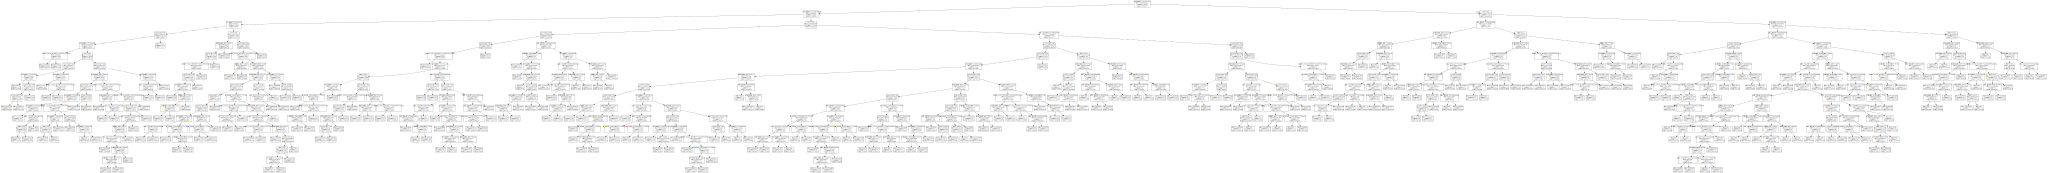

In [60]:
tree_graph = tree.export_graphviz(model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

Major X_train division is at: *population <= 4939791.0* || *mse = 178350.251* || *samples = 4304* || *value = 220.397*

### K-Nearest Neighbors model

Loop and visualize to find K value for the model comparing accuracy at each K value.

Maximum accuracy: 0.06898954703832752 at K Value = 95


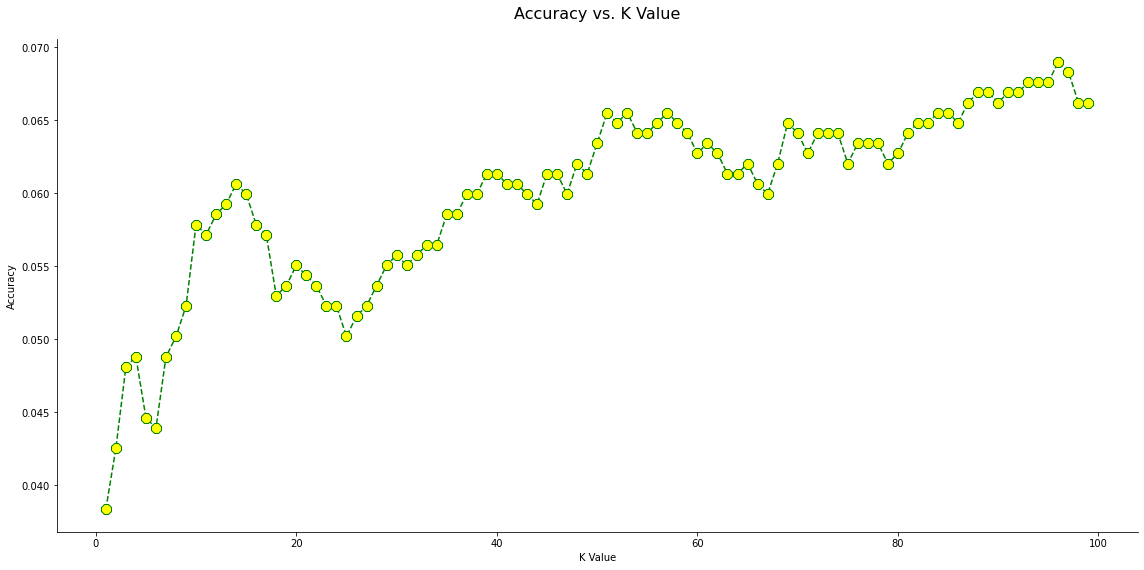

In [61]:
acuracy_list = []  

for i in range(1,100):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    preds = neigh.predict(X_valid)
    acuracy_list.append(metrics.accuracy_score(y_valid, preds))
    
plt.figure(figsize=(16,8))
plt.plot(range(1,100),acuracy_list,color = 'green',linestyle='dashed', 
         marker='8',markerfacecolor='yellow', markersize=10)
[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'right']]
plt.title('Accuracy vs. K Value', fontsize=16, y=1.03)
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.tight_layout()
print("Maximum accuracy:",max(acuracy_list),"at K Value =",acuracy_list.index(max(acuracy_list)))

Initialize K-Nearest Neighbors model with K value *95* and print all scores.

In [62]:
neigh = KNeighborsClassifier(n_neighbors = 95,n_jobs=-1)
neigh.fit(X_train,y_train)
print_score(neigh, X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		474.08699552  
     RMSE Validation set: 	473.09522434 
     r² Train set: 		-0.26020837 
     r² Validation set: 	-0.21898147 
     MAE Train set: 		219.46026952 
     MAE Validation set: 	203.37979094


#### Scaling for Logistic Regression model and Support Vector Regression model

Scale ***train*** and ***validation*** data to \[-1,1\] in order to increase model speed.

In [63]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_scaler = scaling.transform(X_train)
X_valid_scaler = scaling.transform(X_valid)

### Logistic Regression model

Loop through 3 solvers to evaluate accuracy and choose the best performed for the Logistic Regression model.

In [64]:
list_lr = ['newton-cg', 'liblinear', 'sag']

for solver in list_lr:
    lr = linear_model.LogisticRegression(C=0.9, solver=solver).fit(X_train_scaler,y_train)
    y_hat = lr.predict(X_valid_scaler)
    mean_acc = accuracy_score(y_valid,y_hat)
    if solver == 'sag':
        print(f'"{solver}" kernel model accuracy score: \t\t{mean_acc.round(6)}')
    else:
        print(f'"{solver}" kernel model accuracy score: \t{mean_acc.round(6)}')

"newton-cg" kernel model accuracy score: 	0.087805
"liblinear" kernel model accuracy score: 	0.08223
"sag" kernel model accuracy score: 		0.087805


Logistic Regression model with solver as "*newton-cg*" and model's score.

In [65]:
logreg = linear_model.LogisticRegression(C=0.9, solver='newton-cg')
logreg.fit(X_train_scaler,y_train)
print_score_scaler(logreg, X_train_scaler, X_valid_scaler,y_train, y_valid) 

     RMSE Train set: 		310.81243261  
     RMSE Validation set: 	296.16979898 
     r² Train set: 		0.45834465 
     r² Validation set: 	0.5222711 
     MAE Train set: 		131.02253717 
     MAE Validation set: 	124.39790941


### Support Vector Regression model

Loop through 4 kernels to evaluate accuracy and choose the best performed for Support Vector Regression model.

In [66]:
list_svr = ['linear', 'rbf', 'sigmoid','poly']

for model in list_svr:
    svm = SVC(kernel=model).fit(X_train_scaler,y_train)
    y_hat = svm.predict(X_valid_scaler)
    mean_acc = accuracy_score(y_valid,y_hat)
    print(f'{model} kernel model accuracy score:   \t{mean_acc.round(6)}')

linear kernel model accuracy score:   	0.088502
rbf kernel model accuracy score:   	0.081533
sigmoid kernel model accuracy score:   	0.067596
poly kernel model accuracy score:   	0.092683


Support Vector Regression model with kernel as "*poly*" and model's score.

In [67]:
svm = SVC(kernel='poly')
svm.fit(X_train_scaler,y_train)
print_score_scaler(svm, X_train_scaler, X_valid_scaler,y_train, y_valid) 

     RMSE Train set: 		323.34176728  
     RMSE Validation set: 	313.79960316 
     r² Train set: 		0.4137945 
     r² Validation set: 	0.46370375 
     MAE Train set: 		126.49976766 
     MAE Validation set: 	122.88362369


### Lasso (L1) Regression model

Initialize Lasso (L1) Regression model and print all scores.

In [68]:
model_lasso = Lasso()
model_lasso.fit(X_train, y_train)
print_score(model_lasso,X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		260.94823139  
     RMSE Validation set: 	271.85891589 
     r² Train set: 		0.61820082 
     r² Validation set: 	0.5974803 
     MAE Train set: 		158.02820207 
     MAE Validation set: 	163.60415407


#### Test set score

In [69]:
print_score(model_lasso,X_train, X_test,y_train, y_test)

     RMSE Train set: 		260.94823139  
     RMSE Validation set: 	276.49132487 
     r² Train set: 		0.61820082 
     r² Validation set: 	0.59294322 
     MAE Train set: 		158.02820207 
     MAE Validation set: 	161.82354452


### Elastic Net Regression model

Initialize Elastic Net Regression model and print all scores.

In [70]:
model_elastico = ElasticNet()
model_elastico.fit(X_train, y_train)
print_score(model_elastico,X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		281.42227657  
     RMSE Validation set: 	290.28441233 
     r² Train set: 		0.5559384 
     r² Validation set: 	0.54106899 
     MAE Train set: 		148.08318282 
     MAE Validation set: 	152.96328844


### XGBRegressor

Initialize XGBRegressor model and print all scores.

In [71]:
xgboost_model = XGBRegressor(random_state=158,n_estimators = 700, learning_rate = 0.05,objective='reg:squarederror')
xgboost_model.fit(X_train, y_train)
print_score(xgboost_model,X_train, X_valid,y_train, y_valid)

     RMSE Train set: 		76.49721478  
     RMSE Validation set: 	115.55580347 
     r² Train set: 		0.96718915 
     r² Validation set: 	0.92727504 
     MAE Train set: 		45.61209868 
     MAE Validation set: 	60.30805953


#### Test set score

In [72]:
print_score(xgboost_model,X_train, X_test,y_train, y_test)

     RMSE Train set: 		76.49721478  
     RMSE Validation set: 	122.94861269 
     r² Train set: 		0.96718915 
     r² Validation set: 	0.9195105 
     MAE Train set: 		45.61209868 
     MAE Validation set: 	61.10104023


### Random Forest model

Initialize Random Forest baseline model and print all scores.

In [73]:
forest_model = RandomForestRegressor(n_jobs=-1, random_state=158,oob_score=True)
forest_model.fit(X_train, y_train)  
print_score(forest_model, X_train, X_valid,y_train, y_valid)

     oob Score: 		0.93331608
     RMSE Train set: 		40.46307338  
     RMSE Validation set: 	104.08743444 
     r² Train set: 		0.99081997 
     r² Validation set: 	0.94099394 
     MAE Train set: 		14.96038801 
     MAE Validation set: 	38.88105226


#### Feature Improtance

In [74]:
perm = PermutationImportance(forest_model, random_state=158).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
1.3547 ± 0.1163,population
0.4200 ± 0.0727,sex
0.1475 ± 0.0642,5-14 years
0.0636 ± 0.0199,arms_import
0.0632 ± 0.0076,arms_export
0.0364 ± 0.0040,15-24 years
0.0348 ± 0.0066,foreign_exch_reserve
0.0225 ± 0.0079,55-74 years
0.0221 ± 0.0035,75+ years
0.0189 ± 0.0079,gini


#### Tuning RandomForestRegressor hyperparameters

Choose hyperparameter's ranges and initialize all of them into single dictionary.

In [75]:
max_depth = [int(x) for x in np.linspace(start = 20, stop = 30, num = 10)]
min_sample_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
max_leaf_nodes = [int(x) for x in np.linspace(start=2210,stop=2220,num=10)]
min_samples_leaf = [1,3,5]
n_estimators = [int(x) for x in np.linspace(start=100,stop=110,num=10)]
max_features = ['sqrt','log2',0.5,1,'auto']

hyperparameters = {'max_depth': max_depth,
                   'min_samples_split': min_sample_split,
                   'max_leaf_nodes': max_leaf_nodes,
                   'min_samples_leaf': min_samples_leaf,
                   'n_estimators': n_estimators,
                   'max_features': max_features
              }
print('Hyperparameters:')
pprint(hyperparameters )

Hyperparameters:
{'max_depth': [20, 21, 22, 23, 24, 25, 26, 27, 28, 30],
 'max_features': ['sqrt', 'log2', 0.5, 1, 'auto'],
 'max_leaf_nodes': [2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2220],
 'min_samples_leaf': [1, 3, 5],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [100, 101, 102, 103, 104, 105, 106, 107, 108, 110]}


Hyperparameters tuning with RandomizedSearchCV for Random Forest Regressor model.

In [76]:
random_forest = RandomForestRegressor(n_jobs=-1, random_state=158, oob_score=False,bootstrap=False)
params_search = RandomizedSearchCV(estimator=random_forest,
                                   param_distributions=hyperparameters ,
                                   cv = 2, n_iter = 10, random_state=158,
                                   scoring = 'neg_mean_absolute_error')
params_search.fit(X_train, y_train)
print(" RandomizedSearchCV results " )
print("\n The best estimator across ALL searched params:\n", params_search.best_estimator_)
print("\n The best score across ALL searched params:\n", params_search.best_score_)
print("\n The best parameters across ALL searched params:\n", params_search.best_params_)

 RandomizedSearchCV results 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=0.5, max_leaf_nodes=2211,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=103, n_jobs=-1, oob_score=False,
                      random_state=158, verbose=0, warm_start=False)

 The best score across ALL searched params:
 -47.94056691449814

 The best parameters across ALL searched params:
 {'n_estimators': 103, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_leaf_nodes': 2211, 'max_features': 0.5, 'max_depth': 27}


Imbue Random Forest Regressor model with parameters from RandomizedSearchCV.

In [77]:
forest_model_tuning_x = RandomForestRegressor(n_jobs=-1,
                                              random_state=158,
                                              oob_score=True,
                                              max_depth = 27,
                                              min_samples_split = 6,
                                              max_leaf_nodes = 2211,
                                              min_samples_leaf = 1,
                                              n_estimators = 103,
                                              max_features = 0.5
                                             )
forest_model_tuning_x.fit(X_train, y_train)  
print_score(forest_model_tuning_x,X_train, X_valid,y_train, y_valid)

     oob Score: 		0.94130171
     RMSE Train set: 		46.81790003  
     RMSE Validation set: 	99.08156888 
     r² Train set: 		0.98771005 
     r² Validation set: 	0.94653301 
     MAE Train set: 		19.04494087 
     MAE Validation set: 	39.98770195


#### Manual Random Forest Regressor model's hyperparameters tuning  according to RandomizedSearchCV results

Manually searching and adjusting hyperparameters for Random Forest Regressor model:
* max_depth
* min_sample_split
* max_leaf_nodes
* min_samples_leaf
* n_estimators
* max_features

In [78]:
forest_model_tuning_2 = RandomForestRegressor(n_jobs=-1, 
                                            random_state=158,
                                            oob_score=True,
                                            max_depth = 30,
                                            min_samples_split = 2,
                                            max_leaf_nodes = 2200,
                                            min_samples_leaf = 1,
                                            n_estimators = 105,
                                            max_features = 0.5
                                           )
forest_model_tuning_2.fit(X_train, y_train)  
print_score(forest_model_tuning_2,X_train, X_valid,y_train, y_valid)

     oob Score: 		0.94340572
     RMSE Train set: 		37.58242975  
     RMSE Validation set: 	95.83392049 
     r² Train set: 		0.99208053 
     r² Validation set: 	0.9499806 
     MAE Train set: 		14.74368211 
     MAE Validation set: 	38.20241316


Random Forest Regressor model imbue wiht logarithmic scale for dependent variable

In [79]:
forest_model_tuning_3 = RandomForestRegressor(n_jobs=-1, 
                                            random_state=158,
                                            oob_score=True,
                                            max_depth = 30,
                                            min_samples_split = 2,
                                            max_leaf_nodes = 2200,
                                            min_samples_leaf = 1,
                                            n_estimators = 105,
                                            max_features = 0.5)
forest_model_tuning_3.fit(X_train, y_train_log)  
print_score_log(forest_model_tuning_3,X_train, X_valid,y_train_log, y_valid_log)

     oob Score: 		0.96857587
     RMSE Train set: 		44.31669317  
     RMSE Validation set: 	98.80110957 
     r² Train set: 		0.98898813 
     r² Validation set: 	0.94683527 
     MAE Train set: 		14.8237875 
     MAE Validation set: 	35.88345785


#### Test set score

In [80]:
print_score(forest_model_tuning_2,X_train, X_test,y_train, y_test)

     oob Score: 		0.94340572
     RMSE Train set: 		37.58242975  
     RMSE Validation set: 	97.25467565 
     r² Train set: 		0.99208053 
     r² Validation set: 	0.94963684 
     MAE Train set: 		14.74368211 
     MAE Validation set: 	38.30995139


# Scoreboard

##  <center> -=- Validation Set Scoreboard -=-</center>
####  <center> -=- All models -=-</center>

| Model algorithm                 |  RMSE    |    r²    |    MAE   |
| ------------------------------- | -------- | -------- | -------- |
| Random Forest                   |  95.8339 | 0.9500   |  38.2024 |
| XGBRegressor                    | 115.5558 | 0.9273   |  60.3081 |
| DecisionTreeRegressor           | 154.0329 | 0.8708   |  48.2504 |
| Lasso Regression                | 271.8589 | 0.5975   | 163.6042 |
| Linear Regression               | 271.7991 | 0.5977   | 164.7908 |
| Elastic Net Regression          | 290.2844 | 0.5411   | 152.9633 |
| SVM                             | 313.7996 | 0.0927   | 122.8836 |
| LogisticRegression              | 296.1698 | 0.0878   | 124.3979 |
| Linear Regression (with y logp1)| 404.0875 | 0.1107   | 166.8277 |
| K-Nearest Neighbors             | 473.0952 | 0.0676   | 203.3798 |

## <center> -=-  Test Set Scoreboard -=-</center>
####  <center> -=- Random Forest | XGBRegressor |  Linear Regression | Lasso Regression -=-</center>

| Model algorithm                 |  RMSE    |    r²    |    MAE   |
| ------------------------------- | -------- | -------- | -------- |
| Random Forest                   |  97.2547 | 0.9496   |  38.3100 |
| XGBRegressor                    | 122.9486 | 0.9195   |  61.1010 |
| Linear Regression               | 276.4601 | 0.5930   | 163.2822 |
| Lasso Regression                | 276.4913 | 0.5929   | 161.8235 |
| Linear Regression (with y logp1)| 410.2657 | 0.1038   | 172.8310 |